In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import glob
sns.set_context('poster')
sns.set_palette('colorblind')

/Users/Oliver/Library/Python/3.7/lib/python/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [48]:
bro = pd.read_csv('../data/bronze.csv', index_col=0)
bro.drop(bro[bro.KIC == '6603624'].index, inplace=True) # faulty
bro.drop(bro[bro.KIC == '8478994'].index, inplace=True) # fails the by eye check
bro.drop(bro[bro.KIC == '8760414'].index, inplace=True) # faulty & out of range feh
bro.drop(bro[bro.KIC == '8938364'].index, inplace=True) # faulty
bro.drop(bro[bro.KIC == '6278762'].index, inplace=True) # out of range age
bro.drop(bro[bro.KIC == '7106245'].index, inplace=True) # out of range feh
bro.drop(bro[bro.KIC == 'Sun'].index, inplace=True) # out of range feh

print(len(bro))
print(len(np.unique(bro['KIC'])))

3432
89


In [49]:
bro.head(5)

,KIC,n,l,Freq,e_Freq,E_Freq,Amp,e_Amp,E_Amp,Width,...,source,f,f_e,g,g_e,A,A_e,H,H_e,flag
0,1435467,11,1,889.25,0.47,0.53,NaN,NaN,NaN,NaN,...,L,890.192202,0.339219,2.470547,0.295254,2.343982,0.151824,1.413654,0.220290,empty
1,1435467,11,2,920.04,1.82,1.99,NaN,NaN,NaN,NaN,...,L,921.945957,1.156754,2.543673,0.279611,1.601747,0.176437,0.642273,0.154858,empty
2,1435467,12,0,928.22,0.94,0.71,2.39,0.14,0.13,4.79,...,L,927.787406,0.531365,2.561105,0.275386,1.539569,0.175291,0.586035,0.133254,empty
3,1435467,12,1,957.04,0.50,0.46,NaN,NaN,NaN,NaN,...,L,957.508880,0.307417,2.629178,0.260519,2.547766,0.134400,1.570424,0.203176,empty
4,1435467,12,2,989.14,1.24,1.30,NaN,NaN,NaN,NaN,...,L,989.706674,0.520035,2.706434,0.244099,2.212561,0.167521,1.149231,0.206286,empty


## Global diff per star

In [50]:
bro.loc[:, 'diff'] = bro.f - bro.Freq

(-1, 1)

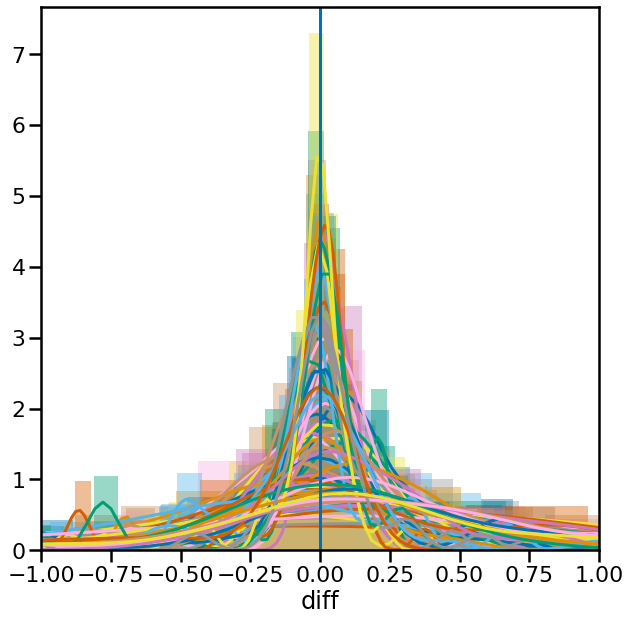

In [51]:
fig, ax = plt.subplots(figsize=(10,10))
for KIC in np.unique(bro.KIC):
    sns.distplot(bro.loc[bro.KIC == KIC, 'diff'].dropna(), label=KIC, ax=ax)
ax.axvline(0)
ax.set_xlim(-1, 1)

## Check diff and diff stds against 0

In [60]:
diffmu = np.zeros(np.unique(bro.KIC).shape)
diffsig = np.zeros(np.unique(bro.KIC).shape)

for idx, KIC in enumerate(np.unique(bro.KIC)):
    diffmu[idx] = np.nanmedian(bro.loc[bro.KIC == KIC, 'diff'])
    diffsig[idx] = np.nanstd(bro.loc[bro.KIC == KIC, 'diff'])

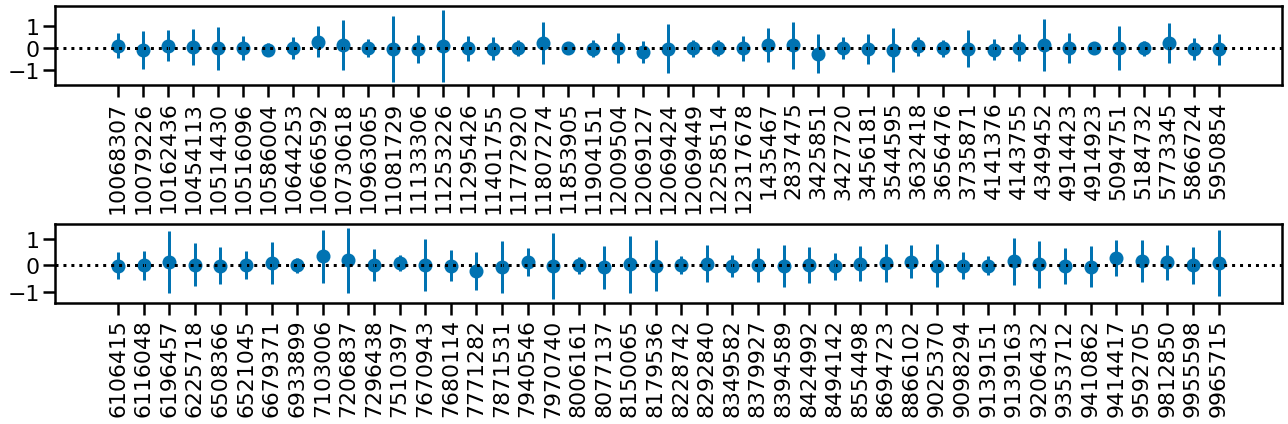

In [76]:
fig, axes = plt.subplots(2, 1, figsize=(18, 6))

ax = axes[0]
ax.axhline(0, c='k', ls=':')
x = np.arange(len(diffmu[:45]))
ax.errorbar(x, diffmu[:45], yerr=diffsig[:45], fmt='|')
ax.scatter(x, diffmu[:45], zorder=2)
ax.set_xticks(np.arange(45))
ax.set_xticklabels(np.unique(bro.KIC)[:45], rotation='vertical')

ax = axes[1]
ax.axhline(0, c='k', ls=':')
x = np.arange(len(diffmu[45:]))
ax.errorbar(x, diffmu[45:], yerr=diffsig[45:], fmt='|')
ax.scatter(x, diffmu[45:], zorder=2)
ax.set_xticks(np.arange(len(diffmu[45:])))
ax.set_xticklabels(np.unique(bro.KIC)[45:], rotation='vertical')
fig.tight_layout()

## Check individual outliers. Are they high SNR?

In [93]:
bro['outflag'] = np.zeros(len(bro))

for idx, KIC in enumerate(np.unique(bro.KIC)):
    diffmu = np.nanmedian(bro.loc[bro.KIC == KIC, 'diff'])
    diffsig = np.nanstd(bro.loc[bro.KIC == KIC, 'diff'])
    bro.loc[np.abs(bro['diff']) > diffmu+(2*diffsig), 'outflag'] = 1
print(f'We have {len(bro.loc[bro.outflag == 1])}/{len(bro)} outliers')

We have 1101/3432 outliers


In [94]:
out = bro.loc[bro.outflag == 1]

In [95]:
bro

,KIC,n,l,Freq,e_Freq,E_Freq,Amp,e_Amp,E_Amp,Width,...,f_e,g,g_e,A,A_e,H,H_e,flag,diff,outflag
0,1435467,11,1,889.25000,0.470000,0.53,NaN,NaN,NaN,NaN,...,0.339219,2.470547,0.295254,2.343982,0.151824,1.413654,0.220290,empty,0.942202,1.0
1,1435467,11,2,920.04000,1.820000,1.99,NaN,NaN,NaN,NaN,...,1.156754,2.543673,0.279611,1.601747,0.176437,0.642273,0.154858,empty,1.905957,1.0
2,1435467,12,0,928.22000,0.940000,0.71,2.39,0.14,0.13,4.79,...,0.531365,2.561105,0.275386,1.539569,0.175291,0.586035,0.133254,empty,-0.432594,1.0
3,1435467,12,1,957.04000,0.500000,0.46,NaN,NaN,NaN,NaN,...,0.307417,2.629178,0.260519,2.547766,0.134400,1.570424,0.203176,empty,0.468880,1.0
4,1435467,12,2,989.14000,1.240000,1.30,NaN,NaN,NaN,NaN,...,0.520035,2.706434,0.244099,2.212561,0.167521,1.149231,0.206286,empty,0.566674,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3671,11904151,20,2,2641.51276,0.308742,NaN,NaN,NaN,NaN,NaN,...,0.197069,1.255149,0.162461,3.213378,0.276865,5.244715,1.121463,empty,0.155756,0.0
3672,11904151,21,0,2646.04161,0.203362,NaN,NaN,NaN,NaN,NaN,...,0.190575,1.264636,0.165083,3.561363,0.286691,6.374101,1.110928,empty,-0.189732,0.0
3673,11904151,21,1,2702.72180,0.234013,NaN,NaN,NaN,NaN,NaN,...,0.145336,1.383773,0.204405,4.323052,0.267583,8.585195,1.487305,empty,-0.185056,0.0
3674,11904151,22,0,2764.10563,0.876573,NaN,NaN,NaN,NaN,NaN,...,0.705632,1.521899,0.262424,3.291544,0.383259,4.475886,0.983957,empty,-0.781318,1.0


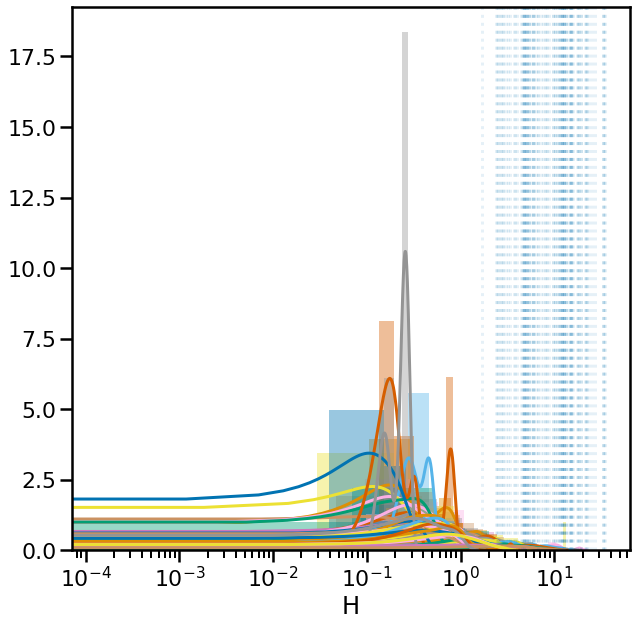

In [100]:
fig, ax = plt.subplots(figsize=(10,10))
for KIC in np.unique(out.KIC):
    sns.distplot(out.loc[out.KIC == KIC, 'H'].dropna(), label=KIC, ax=ax)
    ax.axvline(np.nanmax(bro.loc[bro.KIC == KIC, 'H']), alpha=.1, ls=':')
ax.set_xscale('log')